# Phase 0: Setup

## Step 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from scipy.stats import norm, chi2_contingency, spearmanr
from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RepeatedStratifiedKFold,
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    matthews_corrcoef,
    make_scorer,
    f1_score
)
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
import shap

from catboost import CatBoostClassifier, Pool
import catboost.utils

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

import optuna

## Step 2: Data Loading

In [2]:
unclean_test = pd.read_csv('test.csv')
unclean_train = pd.read_csv('train.csv')

# Phase 1: Exploratory & Statistical Testing

## 1.1: Exploratory Data Analysis
Shape of the data, cleaning the data, monovariate charts, bivariate significance, Mann-WHitney U, Correlation heat-map

### Data Description
Samples (rows): 800
Features (cols): 22

Feature Descriptions:

| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| `ID`                | Unique identifier for each patient                                          |
| `A1_Score` - `A10_Score` | Scores (0 or 1) for each of the 10 AQ screening questions                  |
| `age`               | Age of the patient (in years)                                               |
| `gender`            | Gender of the patient (`m` or `f`)                                          |
| `ethnicity`         | Ethnicity of the patient (12 unique values, e.g., `White-European`)         |
| `jaundice`          | Whether the patient had jaundice at birth (`yes`/`no`)                      |
| `austim`            | Whether an immediate family member has been diagnosed with autism (`yes`/`no`) |
| `contry_of_res`     | Country of residence (56 unique values)                                     |
| `used_app_before`   | Whether the patient has used a screening app before (`yes`/`no`)            |
| `result`            | Composite score for AQ1-10 screening test (float, can be negative)          |
| `age_desc`          | Age description (all values: `18 and more`)                                 |
| `relation`          | Relation of the person completing the test (6 unique values, mostly `Self`)  |
| `Class/ASD`         | Target variable: 0 (No ASD), 1 (ASD)                                        |

In [3]:
unclean_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

All of our variables are not null, so we don't need to worry about that

In [4]:
unclean_train.describe()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.0000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,28.452118,8.537303,0.201250
std,231.0844,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.310966,4.807676,0.401185
min,1.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.718550,-6.137748,0.000000
25%,200.7500,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.198153,5.306575,0.000000
50%,400.5000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.848350,9.605299,0.000000
75%,600.2500,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.865429,12.514484,0.000000
max,800.0000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.461718,15.853126,1.000000


This gives us some quick stats on each of our numerical features.

Below are the numeric columns separated from the rest of the dataset.

In [5]:
unclean_train.iloc[:,[unclean_train[x].dtype != 'object' for x in unclean_train]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         800 non-null    int64  
 1   A1_Score   800 non-null    int64  
 2   A2_Score   800 non-null    int64  
 3   A3_Score   800 non-null    int64  
 4   A4_Score   800 non-null    int64  
 5   A5_Score   800 non-null    int64  
 6   A6_Score   800 non-null    int64  
 7   A7_Score   800 non-null    int64  
 8   A8_Score   800 non-null    int64  
 9   A9_Score   800 non-null    int64  
 10  A10_Score  800 non-null    int64  
 11  age        800 non-null    float64
 12  result     800 non-null    float64
 13  Class/ASD  800 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 87.6 KB


In [6]:
# Create numerical cols list
num_cols = [unclean_train[x].dtype != 'object' for x in unclean_train]

Do the same for categorical features

In [7]:
unclean_train.iloc[:,[unclean_train[x].dtype == 'object' for x in unclean_train]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gender           800 non-null    object
 1   ethnicity        800 non-null    object
 2   jaundice         800 non-null    object
 3   austim           800 non-null    object
 4   contry_of_res    800 non-null    object
 5   used_app_before  800 non-null    object
 6   age_desc         800 non-null    object
 7   relation         800 non-null    object
dtypes: object(8)
memory usage: 50.1+ KB


In [8]:
# Create categorical cols list
cat_cols = [unclean_train[x].dtype == 'object' for x in unclean_train]

Diving a bit deeper into the categorical features, we want to see the unique values in those columns.

In [9]:
for item in unclean_train.iloc[:,cat_cols]:   
    print(item)
    print(unclean_test[item].unique(), end="\n")
 

gender
['m' 'f']
ethnicity
['White-European' 'Asian' '?' 'Middle Eastern ' 'South Asian' 'Pasifika'
 'Turkish' 'Latino' 'Black' 'Others' 'Hispanic']
jaundice
['yes' 'no']
austim
['no' 'yes']
contry_of_res
['India' 'Mexico' 'Egypt' 'Italy' 'Australia' 'United States' 'Jordan'
 'Burundi' 'United Kingdom' 'Canada' 'Germany' 'Russia' 'Spain' 'Austria'
 'Iran' 'New Zealand' 'Bolivia' 'United Arab Emirates' 'Uruguay' 'Lebanon'
 'France' 'Netherlands' 'Bahamas' 'Iceland' 'Sri Lanka' 'Afghanistan'
 'Pakistan' 'Malaysia' 'Aruba' 'Ireland' 'Viet Nam' 'Tonga' 'Philippines'
 'Azerbaijan' 'Czech Republic']
used_app_before
['no' 'yes']
age_desc
['18 and more']
relation
['Self' 'Parent' '?' 'Relative' 'Others' 'Health care professional']


Inspecting our data, we determine that we can convert the `gender`, `austim`, `jaundice`, and `used_app_before` features into numerical values. `age_desc` can be discarded, as it only contains a single value.

Let's also check if the categories of traning data are consistent with the test data or not. If they aren't we'll face issues  during training and prediction.

In [10]:
for item in unclean_train.iloc[:,cat_cols]:
    print(item)
    print([x for x in unclean_test[item].unique() if x not in unclean_train[item].unique()],end = "\n")

gender
[]
ethnicity
[]
jaundice
[]
austim
[]
contry_of_res
['Uruguay', 'Lebanon', 'Philippines']
used_app_before
[]
age_desc
[]
relation
[]


We can see that the countries `Uruguay`, `Lebanon`, and `Philippines` are present in the test set but not the training set. This will cause problems, so we'll have to deal with it in the data preparation step.

### Cleaning the Data

**Reasoning**:
- Remove the 'age_desc': All samples have the same entry for this feature, so we can disregard it 
- Remove the 'ID': This is an arbitrary value that has no impact on our dataset

In [11]:
train = unclean_train.copy()
test = unclean_test.copy()


# Remove the 'age_desc' column.
train.drop('age_desc', axis=1, inplace=True)

# Remove the 'id' column
train.drop('ID', axis=1, inplace=True)

# Check for remaining missing values.
print("\nMissing Values after cleaning:\n", train.isnull().sum())

# Verify the cleaning steps.
display(train.head())
print(train.shape)


Missing Values after cleaning:
 A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jaundice           0
austim             0
contry_of_res      0
used_app_before    0
result             0
relation           0
Class/ASD          0
dtype: int64


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38.172746,f,?,no,no,Austria,no,6.351166,Self,0
1,0,0,0,0,0,0,0,0,0,0,47.750517,m,?,no,no,India,no,2.255185,Self,0
2,1,1,1,1,1,1,1,1,1,1,7.380373,m,White-European,no,yes,United States,no,14.851484,Self,1
3,0,0,0,0,0,0,0,0,0,0,23.561927,f,?,no,no,United States,no,2.276617,Self,0
4,0,0,0,0,0,0,0,0,0,0,43.205790,m,?,no,no,South Africa,no,-4.777286,Self,0


(800, 20)


### Univariate Plots

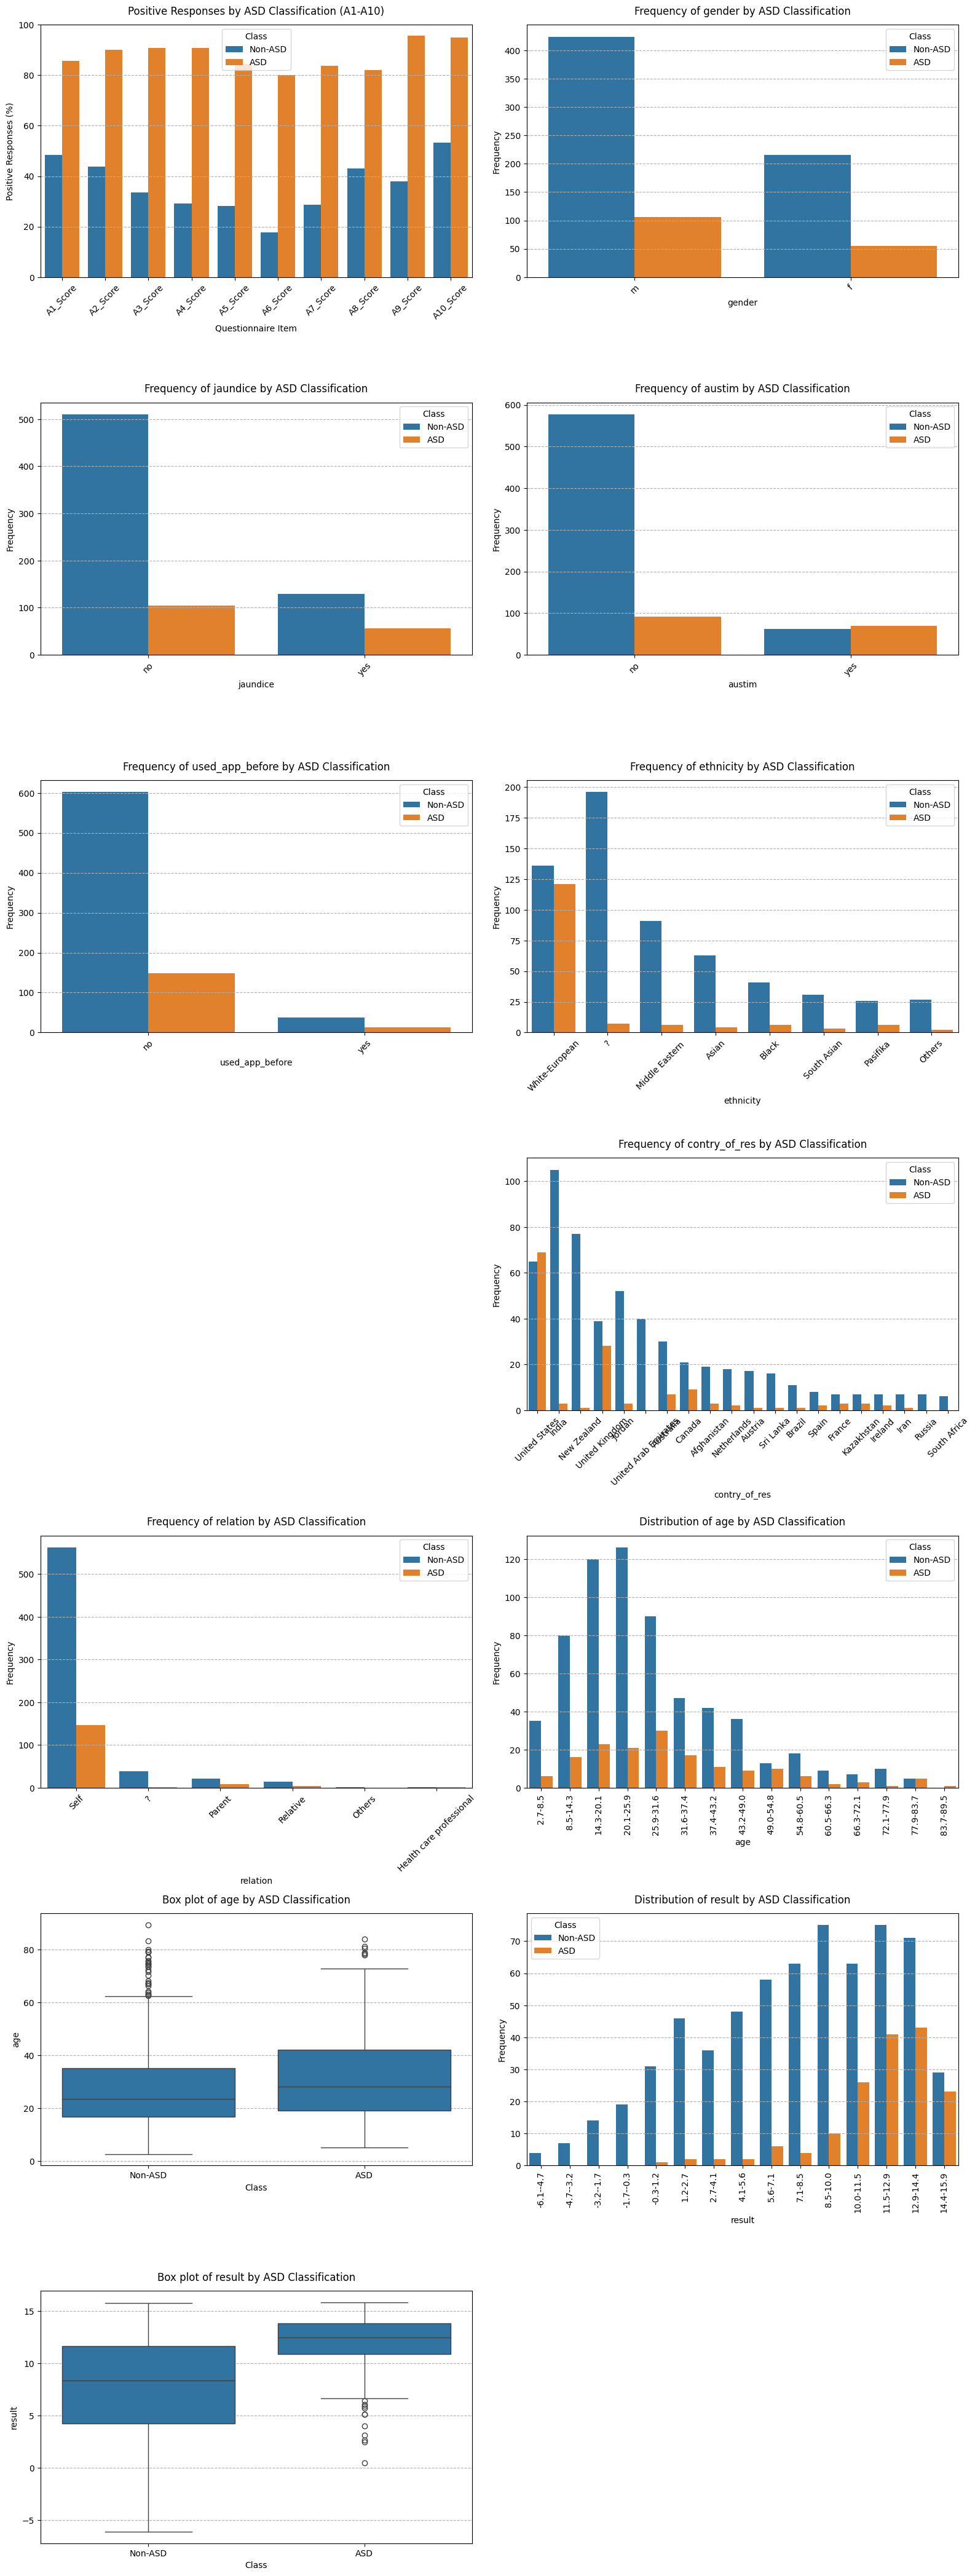

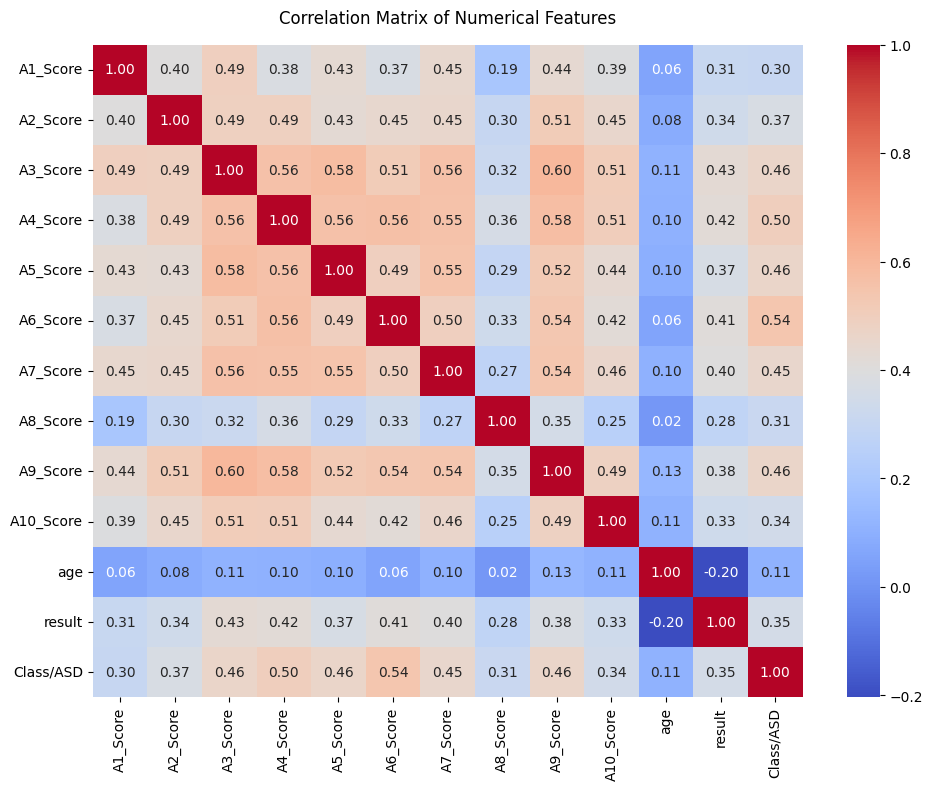

In [12]:
# 4.1
# --- Plotting Functions ---

def plot_positive_frequency_scores(ax, df, score_columns, hue_column='Class/ASD'):
    """
    Bar plot of positive response percentages for binary score columns, grouped by target variable.
    """
    # Create a DataFrame for plotting with scores for each class
    plot_data = []
    
    for class_val in [0, 1]:  # Assuming binary classification (0, 1)
        class_df = df[df[hue_column] == class_val]
        for col in score_columns:
            if col in df.columns and df[col].dropna().isin([0, 1]).all():
                plot_data.append({
                    'Question': col,
                    'Positive_Percentage': class_df[col].mean() * 100,
                    'Class': f"{'ASD' if class_val == 1 else 'Non-ASD'}"
                })
                
    if not plot_data:
        ax.set_visible(False)
        return
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plot grouped bar chart
    sns.barplot(x='Question', y='Positive_Percentage', hue='Class', data=plot_df, ax=ax)
    ax.set_title('Positive Responses by ASD Classification (A1-A10)', y=1.02)
    ax.set_xlabel('Questionnaire Item')
    ax.set_ylabel('Positive Responses (%)')
    ax.set_ylim(0, 100)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--')
    ax.legend(title='Class')


def plot_categorical_bar(ax, df, column_name, hue_column='Class/ASD', top_n=15):
    """
    Bar plot for categorical column frequencies with hue by target variable.
    """
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    
    # Create a DataFrame counting occurrences of each category by class
    plot_data = []
    
    # Get top categories
    top_categories = df[column_name].value_counts(dropna=False).nlargest(top_n).index
    
    for category in top_categories:
        for class_val in [0, 1]:  # Assuming binary classification (0, 1)
            count = len(df[(df[column_name] == category) & (df[hue_column] == class_val)])
            plot_data.append({
                'Category': 'NaN' if pd.isna(category) else category,
                'Count': count,
                'Class': f"{'ASD' if class_val == 1 else 'Non-ASD'}"
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plot grouped bar chart
    sns.barplot(x='Category', y='Count', hue='Class', data=plot_df, ax=ax)
    
    if len(top_categories) > top_n:
        title = f'Top {top_n} for {column_name} by ASD Classification'
    else:
        title = f'Frequency of {column_name} by ASD Classification'
        
    ax.set_title(title, y=1.02)
    ax.set_xlabel(column_name)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--')
    ax.legend(title='Class')


def plot_continuous_hist(ax, df, column_name, hue_column='Class/ASD', bins=20):
    """
    Bar histogram for a continuous column with hue by target variable.
    """
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    
    # Create binned data
    bin_edges = np.histogram_bin_edges(df[column_name].dropna(), bins=bins)
    
    # Create a DataFrame with binned data and class
    plot_data = []
    
    for i in range(len(bin_edges)-1):
        for class_val in [0, 1]:
            class_df = df[df[hue_column] == class_val]
            count = ((class_df[column_name] >= bin_edges[i]) & 
                     (class_df[column_name] < bin_edges[i+1])).sum()
            plot_data.append({
                'Bin': f"{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}",
                'Count': count,
                'Class': f"{'ASD' if class_val == 1 else 'Non-ASD'}",
                'Bin_center': (bin_edges[i] + bin_edges[i+1]) / 2  # For sorting
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Sort by bin center
    plot_df = plot_df.sort_values('Bin_center')
    
    # Plot the bar histogram with hue
    sns.barplot(x='Bin', y='Count', hue='Class', data=plot_df, ax=ax)
    
    ax.set_title(f'Distribution of {column_name} by ASD Classification', y=1.02)
    ax.set_xlabel(column_name)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=90)
    ax.grid(axis='y', linestyle='--')
    ax.legend(title='Class')


def plot_continuous_boxplot(ax, df, column_name, hue_column='Class/ASD'):
    """
    Box plot for a continuous column, grouped by target variable.
    """
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    
    # Create plot data
    plot_data = []
    
    for i, row in df.iterrows():
        class_val = row[hue_column]
        value = row[column_name]
        if not pd.isna(value):
            plot_data.append({
                'Value': value,
                'Class': f"{'ASD' if class_val == 1 else 'Non-ASD'}"
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plot boxplot with hue
    sns.boxplot(x='Class', y='Value', data=plot_df, ax=ax)
    
    ax.set_title(f'Box plot of {column_name} by ASD Classification', y=1.02)
    ax.set_ylabel(column_name)
    ax.set_xlabel('Class')
    ax.grid(axis='y', linestyle='--')


def plot_pie_to_bar(ax, df, column_name, hue_column='Class/ASD', top_n=10):
    """
    Convert pie charts to bar charts showing distribution by target variable.
    """
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    
    # Get top categories
    top_categories = df[column_name].value_counts(dropna=False).nlargest(top_n).index
    
    # Create a DataFrame for plotting
    plot_data = []
    
    for category in top_categories:
        for class_val in [0, 1]:
            count = len(df[(df[column_name] == category) & (df[hue_column] == class_val)])
            plot_data.append({
                'Category': 'NaN' if pd.isna(category) else category,
                'Count': count,
                'Class': f"{'ASD' if class_val == 1 else 'Non-ASD'}"
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plot the bar chart
    sns.barplot(x='Category', y='Count', hue='Class', data=plot_df, ax=ax)
    
    ax.set_title(f'Distribution of {column_name} by ASD Classification', y=1.05)
    ax.set_xlabel(column_name)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--')
    ax.legend(title='Class')


def plot_correlation_heatmap(df, figsize=(10, 8)):
    """
    Heatmap of correlations between numerical features.
    """
    numerical_features = df.select_dtypes(include=['number'])
    correlation_matrix = numerical_features.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features', y=1.02)
    plt.tight_layout()
    plt.show()


# --- Grid Plotting Utility ---

def plot_in_grid(plot_funcs, ncols=3, figsize=(18, 5)):
    """
    Plots a list of (func, args, kwargs) in a grid.
    """
    n_plots = len(plot_funcs)
    nrows = int(np.ceil(n_plots / ncols))
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(figsize[0], figsize[1] * nrows)
    )
    axes = axes.flatten()
    for i, (plot_func, args, kwargs) in enumerate(plot_funcs):
        plot_func(axes[i], *args, **kwargs)
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()


# --- Build Plotting Tasks ---

binary_score_columns = [f'A{i}_Score' for i in range(1, 11)]
categorical_columns = [
    'gender', 'jaundice', 'austim', 'used_app_before', 'ethnicity', 
    'age_desc', 'contry_of_res', 'relation'
]
continuous_columns = ['age', 'result']

plot_funcs = []

# 1. Positive frequency bar (A1-A10)
plot_funcs.append(
    (plot_positive_frequency_scores, (train, binary_score_columns), {})
)

# 2. All categorical variables as bar charts with hue
for col in categorical_columns:
    if col == 'contry_of_res':
        plot_funcs.append(
            (plot_categorical_bar, (train, col), {'top_n': 20})
        )
    elif col == 'ethnicity':
        plot_funcs.append(
            (plot_categorical_bar, (train, col), {'top_n': 8})
        )
    else:
        plot_funcs.append(
            (plot_categorical_bar, (train, col), {})
        )

# 3. Continuous variables as histograms and boxplots
for col in continuous_columns:
    plot_funcs.append(
        (plot_continuous_hist, (train, col), {'bins': 15})
    )
    plot_funcs.append(
        (plot_continuous_boxplot, (train, col), {})
    )

# --- Plot All in a Grid ---

plot_in_grid(plot_funcs, ncols=2, figsize=(16, 6))

# --- Correlation Heatmap (separate plot) ---

plot_correlation_heatmap(train)


**Notes**:
- The ratio of White-European to autistic is far greater than any of the other countries.
- We have a significant amount more males than females in both the ASD and non-ASD groups, with the gender imbalance particularly pronounced in the ASD group.

### Data preparation
Prepare the data for modeling by encoding categorical features, scaling numerical features, and separating predictor and target variables.
1. **Feature type separation:** Identify and separate categorial and numerical features in the `train` dataset
2. **Target exclusion:** Remove the target variable `Class/ASD` from the numerical features list
3. **Categorical Encoding:** Apply one-hot encoding to categorical variables
4. **Data Splitting:** Separate features (X) from the target variable (Y)
5. **Feature Scaling:** Standarizes numerical features using StanrdardSaler to ensure all features contribute equally to the model

**Reasoning**:
Prepare the data for modeling by encoding categorical features, scaling numerical features, and separating predictor and target variables.



In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Identify categorical and numerical features
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('Class/ASD') # Remove target from numerical features

# Encode categorical features using one-hot encoding
df_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)

# Separate features (X) and target (y)
X = df_encoded.drop('Class/ASD', axis=1)
y = df_encoded['Class/ASD']

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

display(X.head())
print(X.shape)
display(y.head())
print(y.shape)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,contry_of_res_United Arab Emirates,contry_of_res_United Kingdom,contry_of_res_United States,contry_of_res_Viet Nam,used_app_before_yes,relation_Health care professional,relation_Others,relation_Parent,relation_Relative,relation_Self
0,0.886405,-1.061913,1.105542,-0.842260,1.237597,-0.660504,1.231147,-1.017656,1.010051,0.787041,...,False,False,False,False,False,False,False,False,False,True
1,-1.128152,-1.061913,-0.904534,-0.842260,-0.808018,-0.660504,-0.812251,-1.017656,-0.990050,-1.270582,...,False,False,False,False,False,False,False,False,False,True
2,0.886405,0.941697,1.105542,1.187282,1.237597,1.513995,1.231147,0.982650,1.010051,0.787041,...,False,False,True,False,False,False,False,False,False,True
3,-1.128152,-1.061913,-0.904534,-0.842260,-0.808018,-0.660504,-0.812251,-1.017656,-0.990050,-1.270582,...,False,False,True,False,False,False,False,False,False,True
4,-1.128152,-1.061913,-0.904534,-0.842260,-0.808018,-0.660504,-0.812251,-1.017656,-0.990050,-1.270582,...,False,False,False,False,False,False,False,False,False,True


(800, 87)


0    0
1    0
2    1
3    0
4    0
Name: Class/ASD, dtype: int64

(800,)


### Chi-square tests


Chi-Square Test Results:

contry_of_res vs relation:
Chi-square statistic: 663.45
p-value: 0.0000
Degrees of freedom: 275

ethnicity vs Class/ASD:
Chi-square statistic: 181.02
p-value: 0.0000
Degrees of freedom: 11

austim vs Class/ASD:
Chi-square statistic: 100.82
p-value: 0.0000
Degrees of freedom: 1

contry_of_res vs Class/ASD:
Chi-square statistic: 205.75
p-value: 0.0000
Degrees of freedom: 55

ethnicity vs austim:
Chi-square statistic: 98.23
p-value: 0.0000
Degrees of freedom: 11

austim vs contry_of_res:
Chi-square statistic: 149.74
p-value: 0.0000
Degrees of freedom: 55

ethnicity vs relation:
Chi-square statistic: 114.11
p-value: 0.0000
Degrees of freedom: 55

ethnicity vs jaundice:
Chi-square statistic: 37.17
p-value: 0.0001
Degrees of freedom: 11

jaundice vs Class/ASD:
Chi-square statistic: 14.60
p-value: 0.0001
Degrees of freedom: 1

jaundice vs austim:
Chi-square statistic: 8.96
p-value: 0.0028
Degrees of freedom: 1

contry_of_res vs used_app_before:
Chi-square statistic:

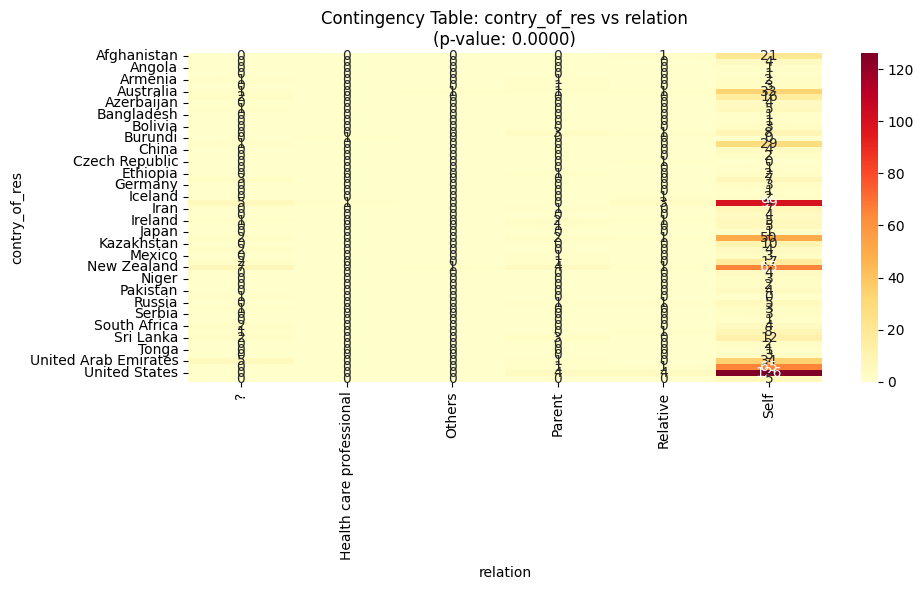

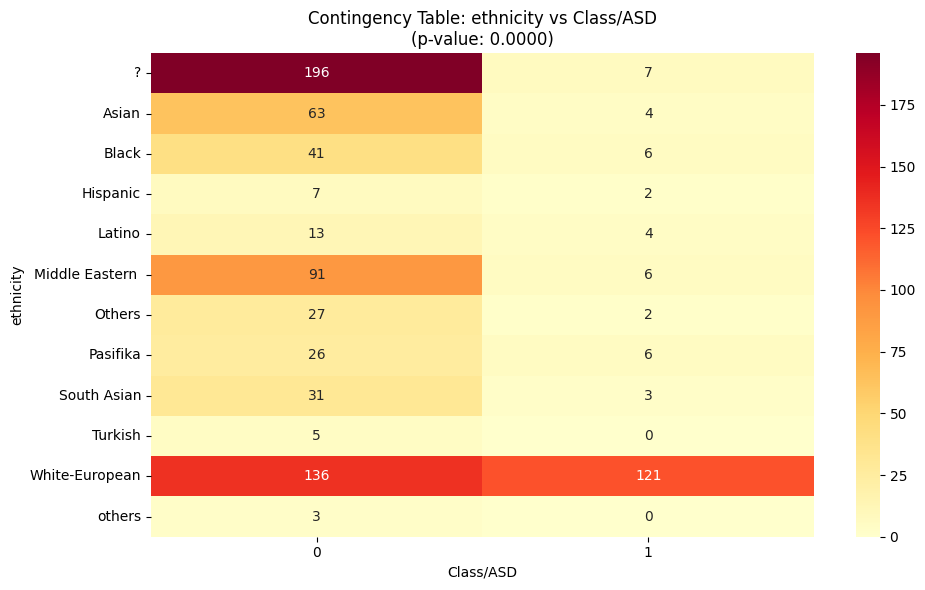

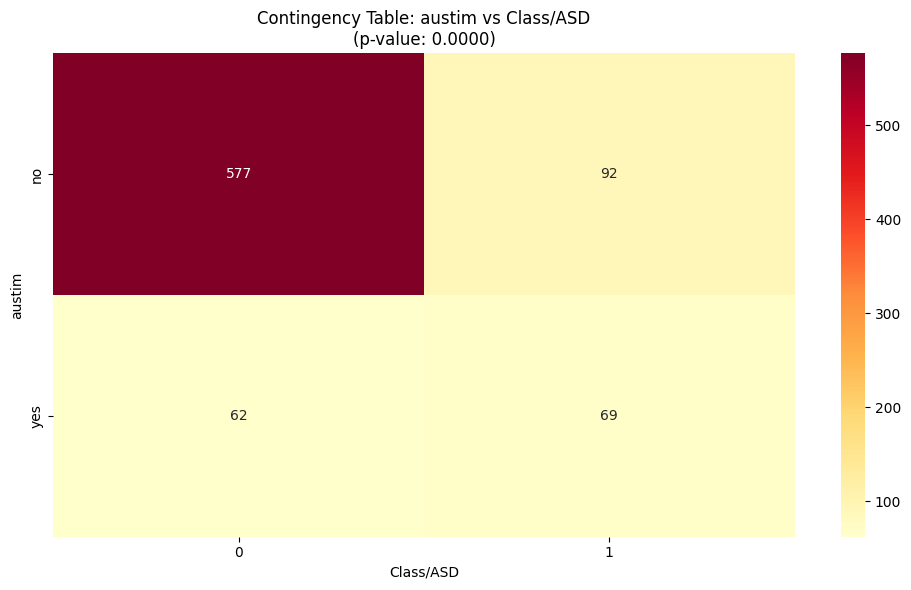

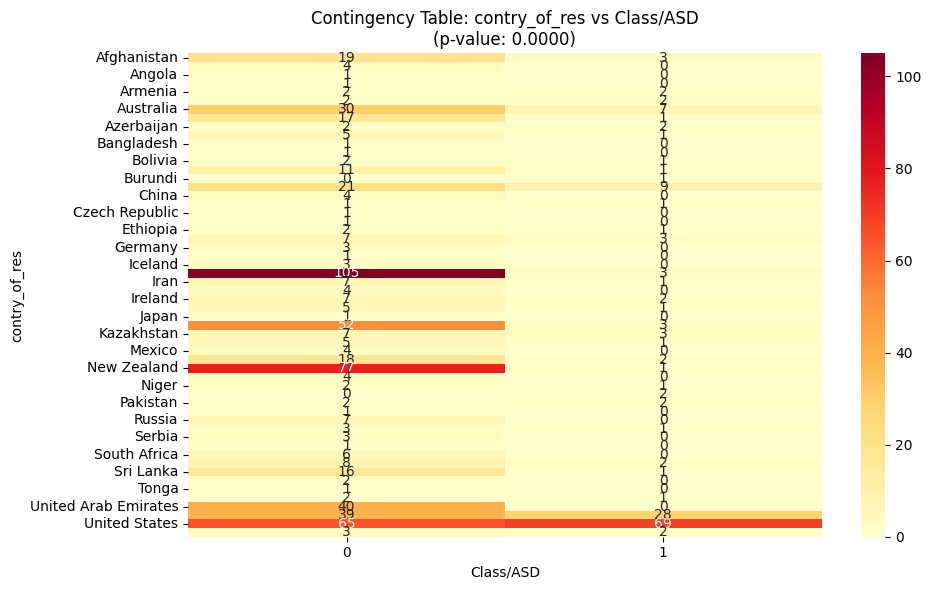

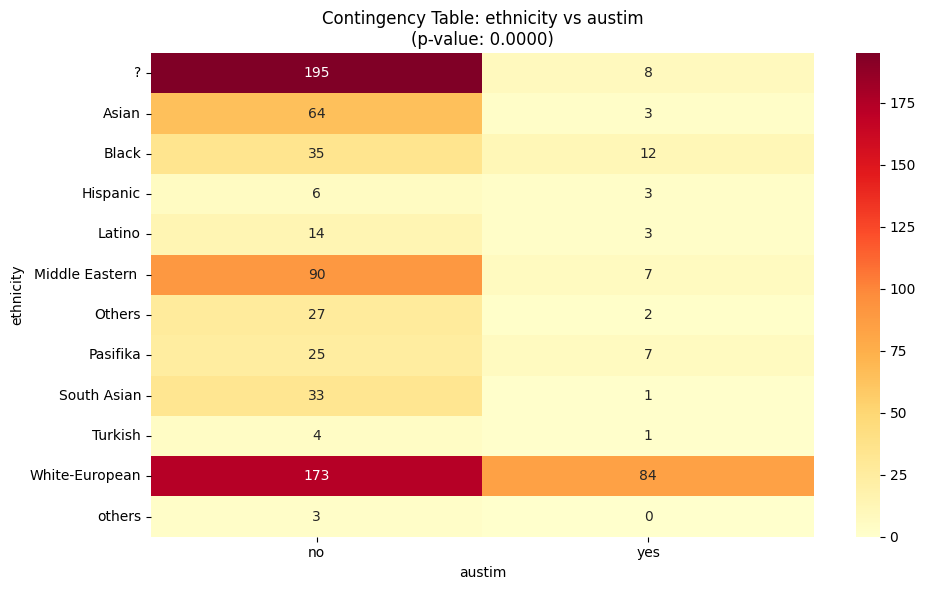

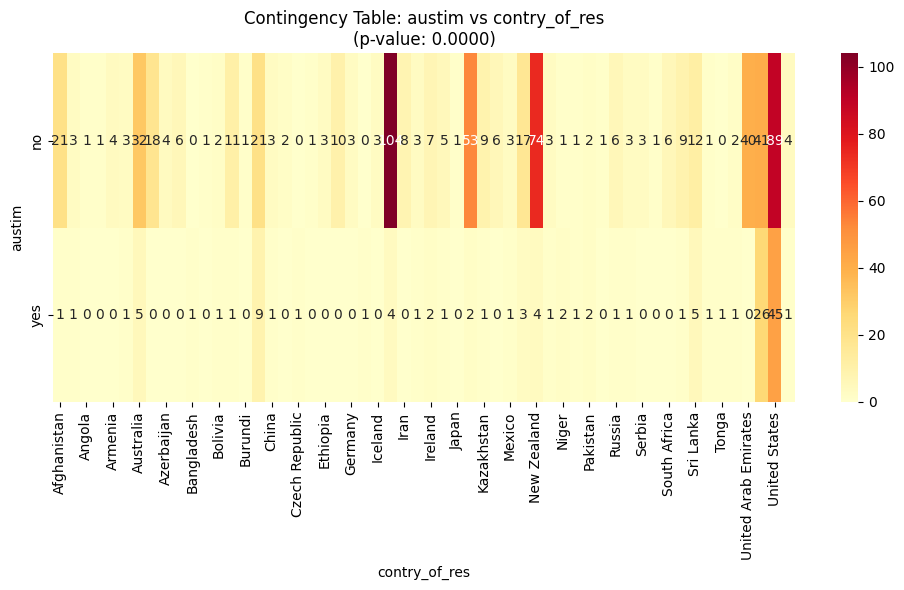

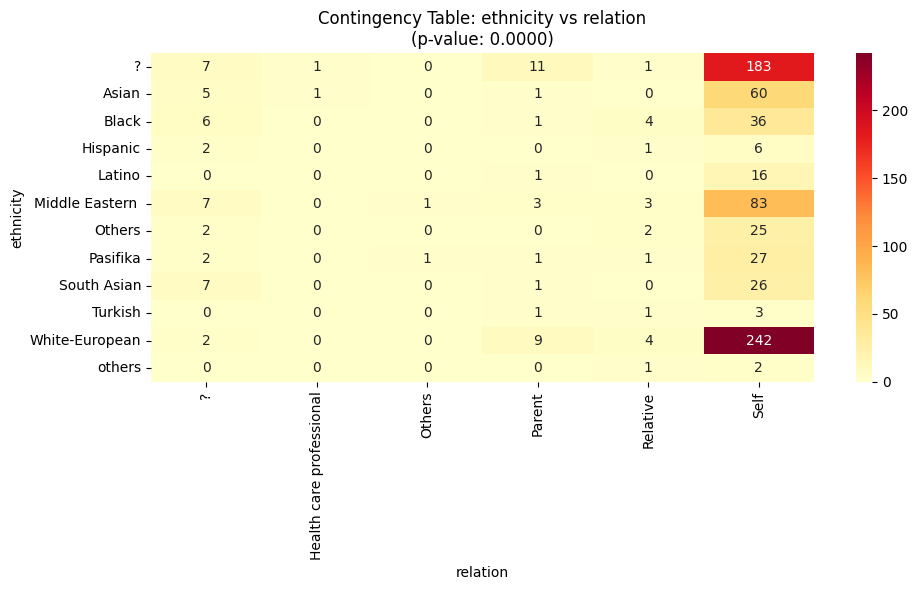

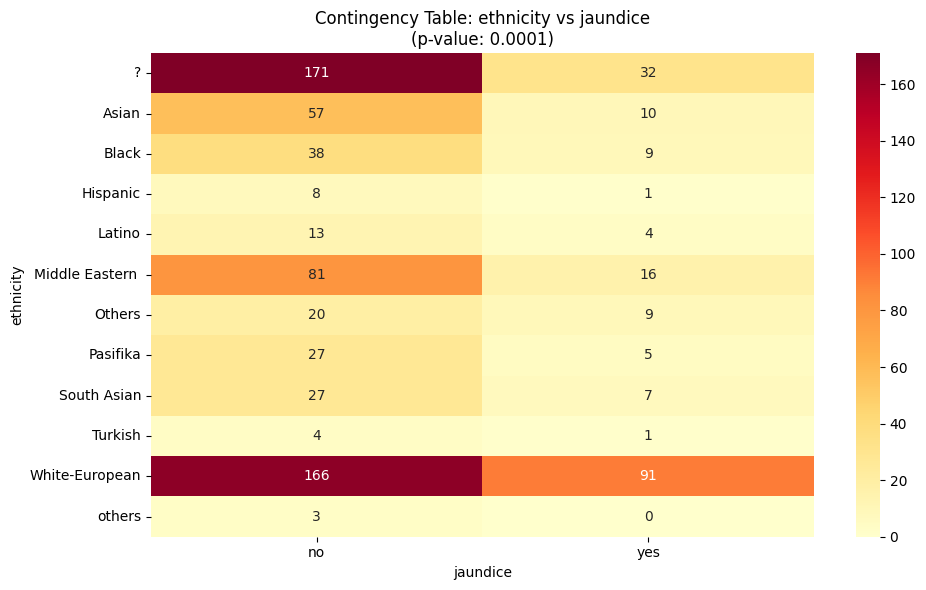

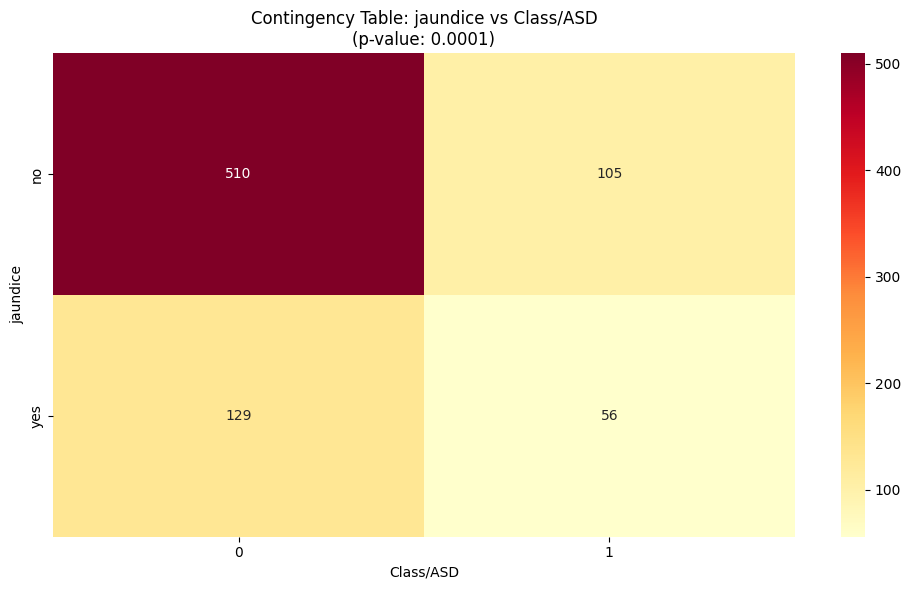

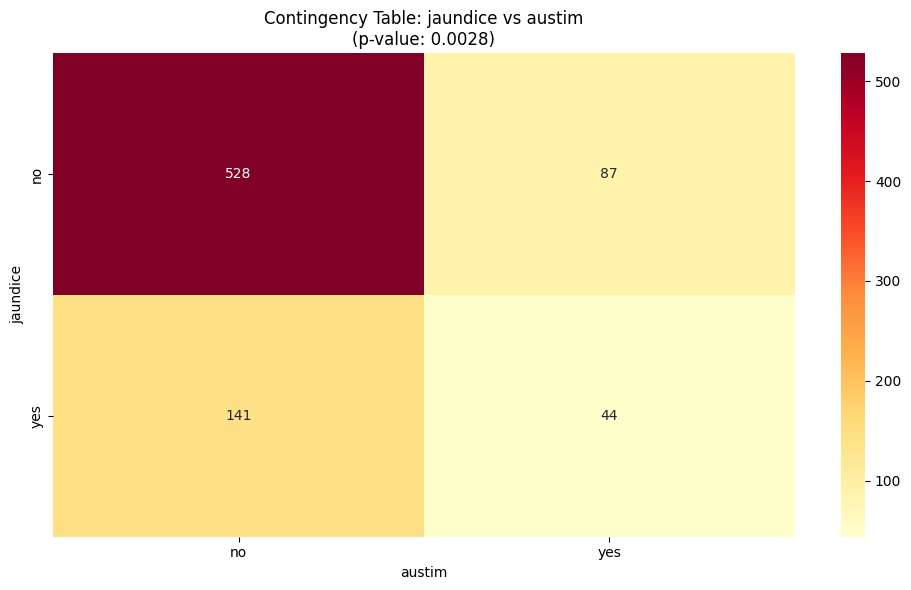

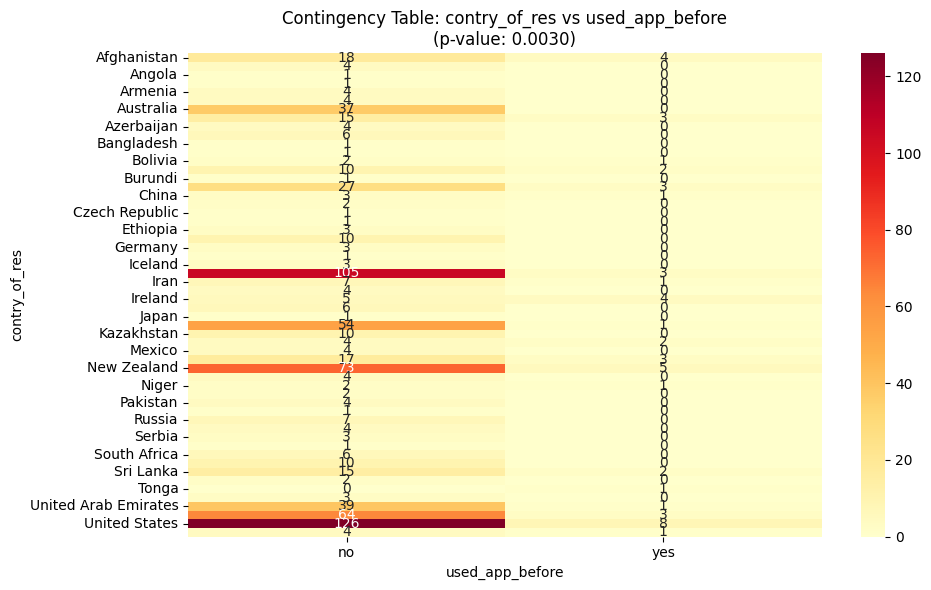

In [14]:
#@title Chi-square (x^2) test of independence
def create_contingency_table(df, var1, var2):
    """Create a contingency table for two categorical variables"""
    return pd.crosstab(df[var1], df[var2])

def perform_chi_square_test(contingency_table):
    """Perform chi-square test of independence"""
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    return {
        'chi2_statistic': chi2,
        'p_value': p_value,
        'degrees_of_freedom': dof
    }

def analyze_categorical_variables(df):
    """Perform chi-square tests on all pairs of categorical variables"""
    categorical_cols = ['gender', 'ethnicity', 'jaundice', 'austim', 
                       'contry_of_res', 'used_app_before', 
                       'relation', 'Class/ASD']
    
    results = []
    
    for i in range(len(categorical_cols)):
        for j in range(i + 1, len(categorical_cols)):
            var1 = categorical_cols[i]
            var2 = categorical_cols[j]
            
            # Create contingency table
            contingency_table = create_contingency_table(df, var1, var2)
            
            # Perform chi-square test
            test_result = perform_chi_square_test(contingency_table)
            
            results.append({
                'variable1': var1,
                'variable2': var2,
                'chi2_statistic': test_result['chi2_statistic'],
                'p_value': test_result['p_value'],
                'degrees_of_freedom': test_result['degrees_of_freedom']
            })
    
    return pd.DataFrame(results)

def plot_significant_relationships(df, results, p_threshold=0.05):
    """Plot contingency tables for significant relationships"""
    significant_results = results[results['p_value'] < p_threshold]
    
    for _, row in significant_results.iterrows():
        var1 = row['variable1']
        var2 = row['variable2']
        
        plt.figure(figsize=(10, 6))
        contingency_table = create_contingency_table(df, var1, var2)
        sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlOrRd')
        plt.title(f'Contingency Table: {var1} vs {var2}\n(p-value: {row["p_value"]:.4f})')
        plt.tight_layout()
        plt.show()
    

results = analyze_categorical_variables(train)

# Sort results by p-value
results = results.sort_values('p_value')

# Print results
print("\nChi-Square Test Results:")
print("========================")
for _, row in results.iterrows():
    print(f"\n{row['variable1']} vs {row['variable2']}:")
    print(f"Chi-square statistic: {row['chi2_statistic']:.2f}")
    print(f"p-value: {row['p_value']:.4f}")
    print(f"Degrees of freedom: {row['degrees_of_freedom']}")

# Plot significant relationships
print("\nPlotting significant relationships (p < 0.05)...")
plot_significant_relationships(train, results)

Mann-Whitney U test results:
U statistic: 59584.00
p-value: 0.0019


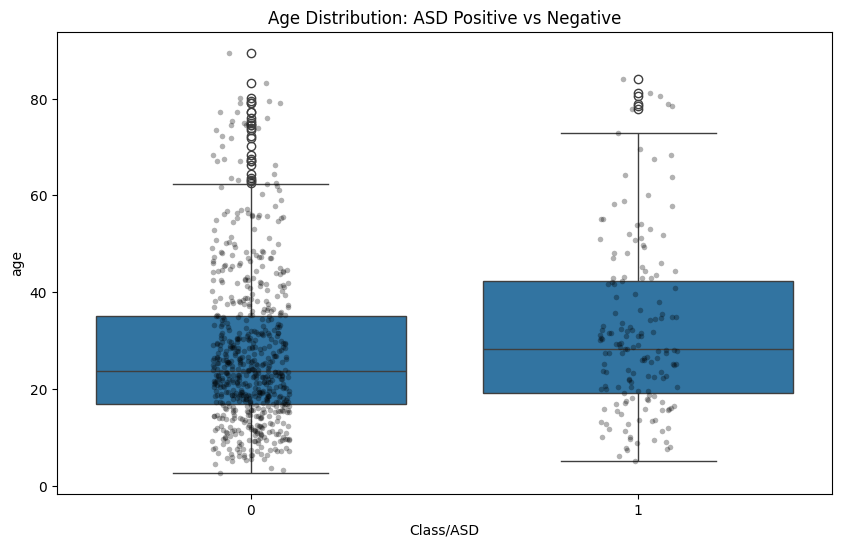

In [15]:
#@title Mann-Whiteney U Test
def perform_mann_whitney_test(data, group_column, value_column, group1, group2):
    """
    Perform Mann-Whitney U test between two groups.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    group_column : str
        Column name containing group labels
    value_column : str
        Column name containing values to compare
    group1 : str/int
        Label of first group
    group2 : str/int
        Label of second group
    
    Returns:
    --------
    tuple
        (U statistic, p-value)
    """
    # Extract values for each group
    group1_values = data[data[group_column] == group1][value_column]
    group2_values = data[data[group_column] == group2][value_column]
    
    # Perform Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(
        group1_values, 
        group2_values, 
        alternative='two-sided'
    )
    
    return statistic, p_value

def plot_group_comparison(data, group_column, value_column, group1, group2, title=None):
    """
    Create a box plot comparing the distribution of values between two groups.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    group_column : str
        Column name containing group labels
    value_column : str
        Column name containing values to compare
    group1 : str/int
        Label of first group
    group2 : str/int
        Label of second group
    title : str, optional
        Plot title
    """
    plt.figure(figsize=(10, 6))
    
    # Create box plot
    sns.boxplot(x=group_column, y=value_column, data=data[data[group_column].isin([group1, group2])])
    
    # Add individual points
    sns.stripplot(x=group_column, y=value_column, data=data[data[group_column].isin([group1, group2])],
                 color='black', alpha=0.3, size=4)
    
    if title:
        plt.title(title)
    plt.show()
    
# Example: Compare age distribution between ASD positive and negative groups
statistic, p_value = perform_mann_whitney_test(
    train, 
    'Class/ASD', 
    'age',
    1,  # ASD positive
    0   # ASD negative
)

print(f"Mann-Whitney U test results:")
print(f"U statistic: {statistic:.2f}")
print(f"p-value: {p_value:.4f}")

# Create visualization
plot_group_comparison(
    train,
    'Class/ASD',
    'age',
    1,
    0,
    title='Age Distribution: ASD Positive vs Negative'
) 

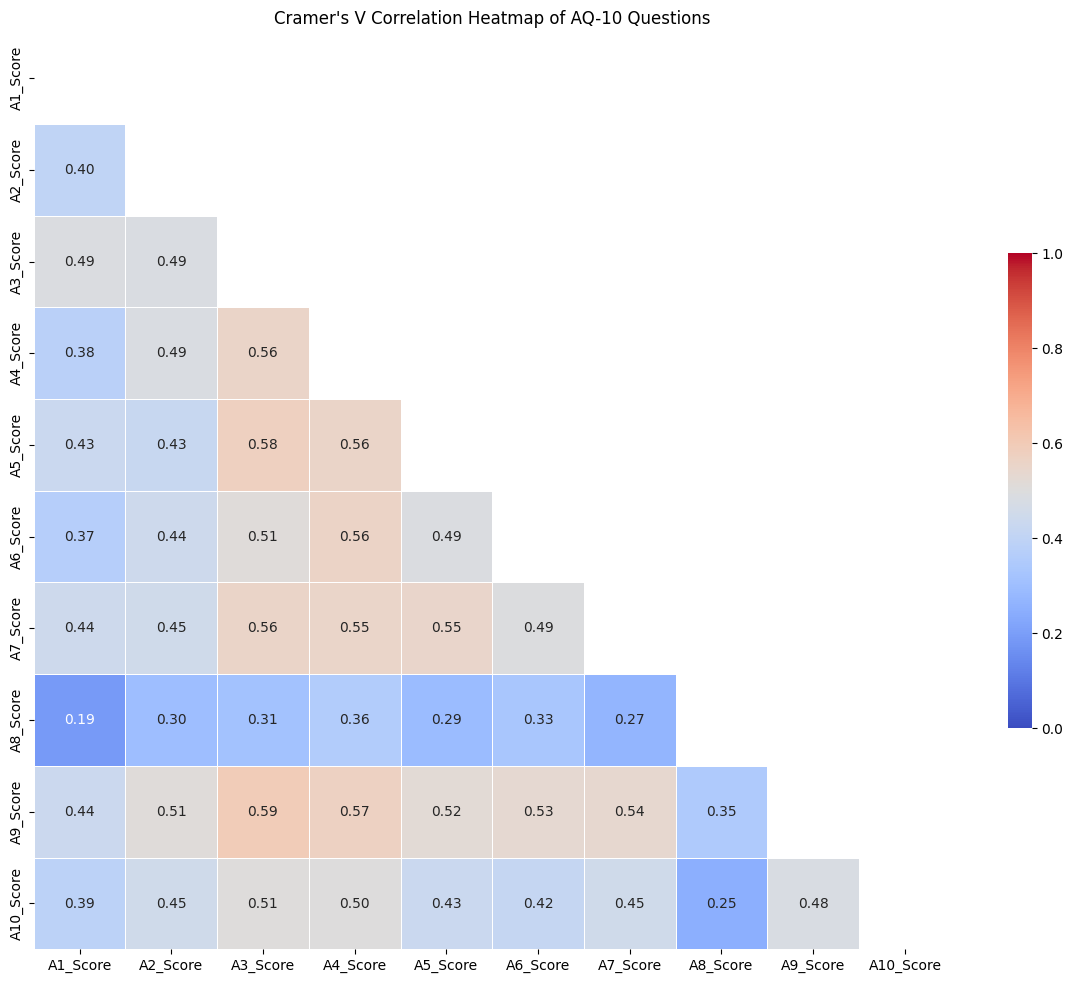


Top 5 strongest correlations between AQ-10 questions:
A3_Score - A9_Score: 0.595
A3_Score - A5_Score: 0.577
A4_Score - A9_Score: 0.574
A4_Score - A6_Score: 0.561
A4_Score - A5_Score: 0.557


In [16]:
#@title Cramér’s V
def cramers_v(confusion_matrix):
    """
    Calculate Cramer's V statistic for categorical-categorical association.
    
    Parameters:
    -----------
    confusion_matrix : numpy.ndarray
        The confusion matrix (contingency table)
    
    Returns:
    --------
    float
        Cramer's V statistic
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    
    return np.sqrt(chi2 / (n * min_dim))

def calculate_cramers_v_matrix(data, columns):
    """
    Calculate Cramer's V for all pairs of categorical variables.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    columns : list
        List of column names to analyze
    
    Returns:
    --------
    pandas.DataFrame
        Matrix of Cramer's V values
    """
    n_cols = len(columns)
    cramers_v_matrix = np.zeros((n_cols, n_cols))
    
    for i in range(n_cols):
        for j in range(n_cols):
            if i == j:
                cramers_v_matrix[i, j] = 1.0
            else:
                confusion_matrix = pd.crosstab(data[columns[i]], data[columns[j]])
                cramers_v_matrix[i, j] = cramers_v(confusion_matrix)
    
    return pd.DataFrame(cramers_v_matrix, index=columns, columns=columns)

def plot_correlation_heatmap(correlation_matrix, title="Cramer's V Correlation Heatmap"):
    """
    Create a heatmap visualization of the correlation matrix.
    
    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        The correlation matrix to visualize
    title : str
        Title for the plot
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                vmin=0,
                vmax=1,
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5})
    
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Get AQ-10 score columns
aq_columns = [col for col in train.columns if col.startswith('A') and col.endswith('_Score')]

# Calculate Cramer's V matrix
cramers_v_matrix = calculate_cramers_v_matrix(train, aq_columns)

# Plot correlation heatmap
plot_correlation_heatmap(
    cramers_v_matrix,
    title="Cramer's V Correlation Heatmap of AQ-10 Questions"
)

# Print some insights
print("\nTop 5 strongest correlations between AQ-10 questions:")
# Get upper triangle of correlation matrix
upper_triangle = cramers_v_matrix.where(np.triu(np.ones(cramers_v_matrix.shape), k=1).astype(bool))
# Stack and sort
correlations = upper_triangle.stack().sort_values(ascending=False)
for (q1, q2), corr in correlations.head().items():
    print(f"{q1} - {q2}: {corr:.3f}") 

## Polychoric Correlation

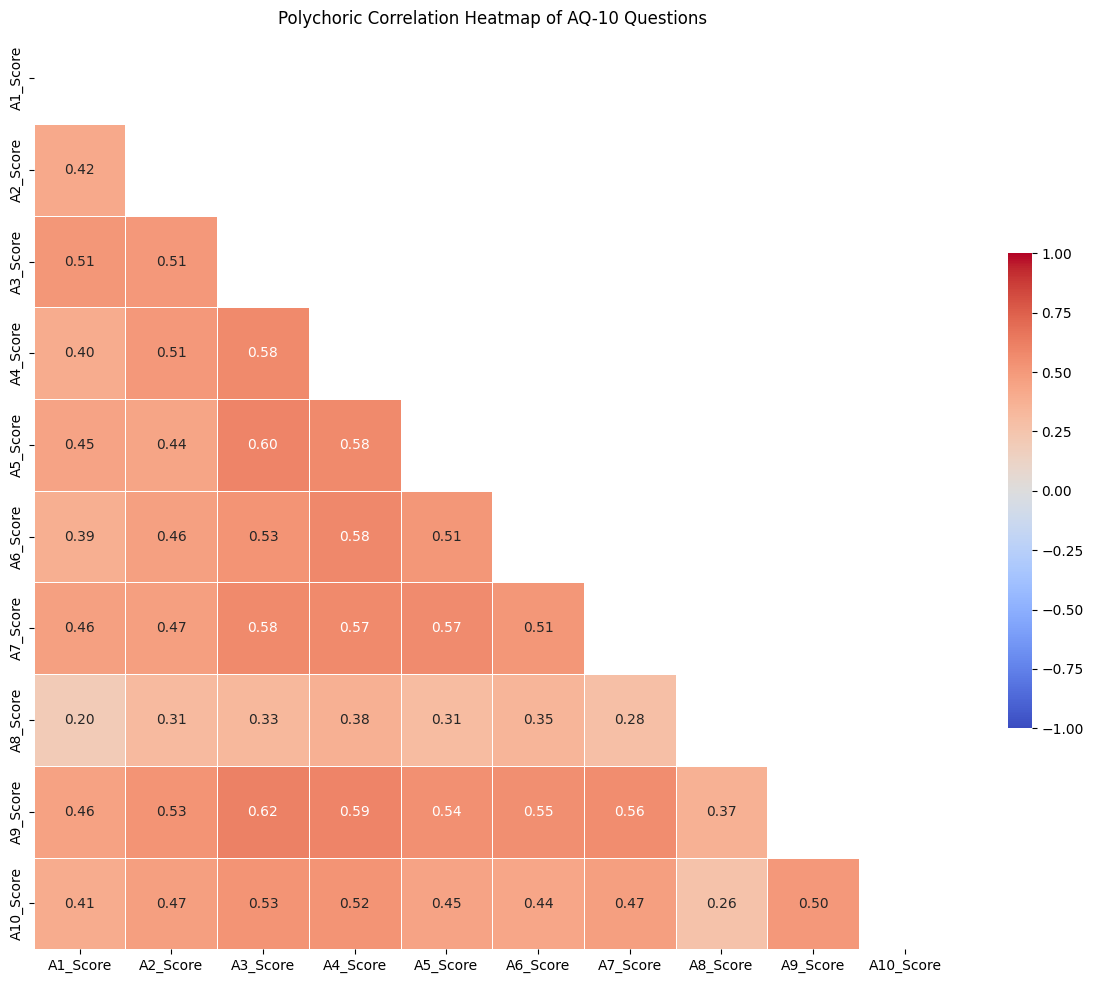


Top 5 strongest correlations between AQ-10 questions:
A3_Score - A9_Score: 0.615
A3_Score - A5_Score: 0.598
A4_Score - A9_Score: 0.595
A4_Score - A6_Score: 0.582
A4_Score - A5_Score: 0.578


In [17]:
#@title Polychoric correlation
def polychoric_approx(x, y):
    """
    Calculate an approximation of polychoric correlation
    using Pearson correlation with a correction factor.
    
    Parameters:
    -----------
    x : pandas.Series
        First ordinal variable
    y : pandas.Series
        Second ordinal variable
        
    Returns:
    --------
    float
        Approximate polychoric correlation coefficient
    """
    # Handle missing values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Use Spearman correlation as starting point
    rho_spearman, _ = stats.spearmanr(x_clean, y_clean)
    
    # Apply correction to approximate polychoric correlation
    # This uses a common rule of thumb for converting Spearman to polychoric
    rho_polychoric = 2 * np.sin(np.pi * rho_spearman / 6)
    
    return rho_polychoric

def calculate_polychoric_matrix(data, columns):
    """
    Calculate polychoric correlation for all pairs of ordinal variables.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    columns : list
        List of column names to analyze
    
    Returns:
    --------
    pandas.DataFrame
        Matrix of polychoric correlation values
    """
    n_cols = len(columns)
    polychoric_matrix = np.zeros((n_cols, n_cols))
    
    for i in range(n_cols):
        for j in range(n_cols):
            if i == j:
                polychoric_matrix[i, j] = 1.0
            else:
                polychoric_matrix[i, j] = polychoric_approx(data[columns[i]], data[columns[j]])
    
    return pd.DataFrame(polychoric_matrix, index=columns, columns=columns)

def plot_polychoric_heatmap(correlation_matrix, title="Polychoric Correlation Heatmap"):
    """
    Create a heatmap visualization of the polychoric correlation matrix.
    
    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        The correlation matrix to visualize
    title : str
        Title for the plot
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                vmin=-1,
                vmax=1,
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5})
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage:
# Get AQ-10 score columns
aq_columns = [col for col in train.columns if col.startswith('A') and col.endswith('_Score')]

# Calculate polychoric correlation matrix
polychoric_matrix = calculate_polychoric_matrix(train, aq_columns)

# Plot correlation heatmap
plot_polychoric_heatmap(
    polychoric_matrix, 
    title="Polychoric Correlation Heatmap of AQ-10 Questions"
)

# Print some insights
print("\nTop 5 strongest correlations between AQ-10 questions:")
# Get upper triangle of correlation matrix
upper_triangle = polychoric_matrix.where(np.triu(np.ones(polychoric_matrix.shape), k=1).astype(bool))
# Take absolute values for the strongest correlations (positive or negative)
abs_correlations = upper_triangle.abs().stack().sort_values(ascending=False)
for (q1, q2), corr in abs_correlations.head().items():
    actual_corr = upper_triangle.loc[q1, q2]
    print(f"{q1} - {q2}: {actual_corr:.3f}")

# Phase 2: Supervised Learning Benchmarks

## Robbie

(800, 20)
['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result']
['gender', 'ethnicity', 'jaundice', 'austim']
   A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0         1         0         1         0         1         0         1   
1         0         0         0         0         0         0         0   
2         1         1         1         1         1         1         1   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   A8_Score  A9_Score  A10_Score  ...  ethnicity_Latino  \
0         0         1          1  ...             False   
1         0         0          0  ...             False   
2         1         1          1  ...             False   
3         0         0          0  ...             False   
4         0         0          0  ...             False   


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,ethnicity_Latino,ethnicity_Middle Eastern,ethnicity_Others,ethnicity_Pasifika,ethnicity_South Asian,ethnicity_Turkish,ethnicity_White-European,ethnicity_others,jaundice_yes,austim_yes
0,1,0,1,0,1,0,1,0,1,1,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,1,1,1,1,1,1,1,1,1,1,...,False,False,False,False,False,False,True,False,False,True
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


(800, 26)


0    0
1    0
2    1
3    0
4    0
Name: Class/ASD, dtype: int64

[I 2025-05-11 15:47:07,959] A new study created in memory with name: no-name-ff9c0c01-a988-4d10-a63e-8facf77218e9


(800,)
Tuning Logistic Regression...


[I 2025-05-11 15:47:08,211] Trial 0 finished with value: 0.8416612121384595 and parameters: {'penalty': 'l1', 'C': 0.0032195459647967675}. Best is trial 0 with value: 0.8416612121384595.
[I 2025-05-11 15:47:08,508] Trial 1 finished with value: 0.8416612121384595 and parameters: {'penalty': 'l1', 'C': 0.008661518659378588}. Best is trial 0 with value: 0.8416612121384595.
[I 2025-05-11 15:47:08,978] Trial 2 finished with value: 0.8833174440555127 and parameters: {'penalty': 'l2', 'C': 0.06277307281334371}. Best is trial 2 with value: 0.8833174440555127.
[I 2025-05-11 15:47:09,181] Trial 3 finished with value: 0.8490513863987783 and parameters: {'penalty': 'l2', 'C': 0.0020552441249896795}. Best is trial 2 with value: 0.8833174440555127.
[I 2025-05-11 15:47:10,081] Trial 4 finished with value: 0.8888294819621124 and parameters: {'penalty': 'l1', 'C': 0.21904951636364375}. Best is trial 4 with value: 0.8888294819621124.
[I 2025-05-11 15:47:10,652] Trial 5 finished with value: 0.88755300378

Tuning Random Forest...


[I 2025-05-11 15:47:58,895] Trial 0 finished with value: 0.8583791039395923 and parameters: {'n_estimators': 109, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8583791039395923.
[I 2025-05-11 15:48:07,599] Trial 1 finished with value: 0.895530251287743 and parameters: {'n_estimators': 173, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.895530251287743.
[I 2025-05-11 15:48:16,247] Trial 2 finished with value: 0.9110850242370775 and parameters: {'n_estimators': 174, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.9110850242370775.
[I 2025-05-11 15:48:28,581] Trial 3 finished with value: 0.8765298765853706 and parameters: {'n_estimators': 263, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.9110850242370775.
[I 2025-05-11 15:48:37,330] Trial 4 finished with value: 0.885461903677775 and parameters: {'n_e

Tuning XGBoost...


[I 2025-05-11 15:54:19,749] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 159, 'max_depth': 10, 'learning_rate': 0.001561653497817176, 'gamma': 4.911174606960266, 'subsample': 0.5483470636517775, 'colsample_bytree': 0.6786187064659994, 'reg_alpha': 4.735100987381543, 'reg_lambda': 4.03133367395043}. Best is trial 0 with value: 0.5.
[I 2025-05-11 15:54:21,922] Trial 1 finished with value: 0.7717380735554986 and parameters: {'n_estimators': 62, 'max_depth': 6, 'learning_rate': 0.012230399631063567, 'gamma': 0.665845320546048, 'subsample': 0.8635557812262673, 'colsample_bytree': 0.8763959847851603, 'reg_alpha': 4.556083566367875, 'reg_lambda': 1.9185687723352607}. Best is trial 1 with value: 0.7717380735554986.
[I 2025-05-11 15:54:24,335] Trial 2 finished with value: 0.8553853979908366 and parameters: {'n_estimators': 156, 'max_depth': 11, 'learning_rate': 0.28596629877330426, 'gamma': 4.969593801847046, 'subsample': 0.5815950003302401, 'colsample_bytree': 0.7358785337

Tuning CatBoost...


[I 2025-05-11 15:57:09,324] Trial 0 finished with value: 0.8540027936670556 and parameters: {'iterations': 147, 'depth': 10, 'learning_rate': 0.0074701086559676045, 'l2_leaf_reg': 7.990523471841022}. Best is trial 0 with value: 0.8540027936670556.
[I 2025-05-11 15:57:38,612] Trial 1 finished with value: 0.8423011705891841 and parameters: {'iterations': 192, 'depth': 8, 'learning_rate': 0.002348582375571879, 'l2_leaf_reg': 8.871596464917449}. Best is trial 0 with value: 0.8540027936670556.
[I 2025-05-11 15:57:47,182] Trial 2 finished with value: 0.8794552823548384 and parameters: {'iterations': 147, 'depth': 3, 'learning_rate': 0.06904160898677777, 'l2_leaf_reg': 2.367451404616067}. Best is trial 2 with value: 0.8794552823548384.
[I 2025-05-11 15:58:02,243] Trial 3 finished with value: 0.8426153988445885 and parameters: {'iterations': 92, 'depth': 8, 'learning_rate': 0.007244680191791606, 'l2_leaf_reg': 7.515240396735953}. Best is trial 2 with value: 0.8794552823548384.
[I 2025-05-11 15


Training and evaluating: Logistic Regression
Logistic Regression Test Accuracy: 0.7812 | ROC-AUC: 0.8430 | PR-AUC: 0.6198 | F1: 0.5783 | MCC: 0.4627


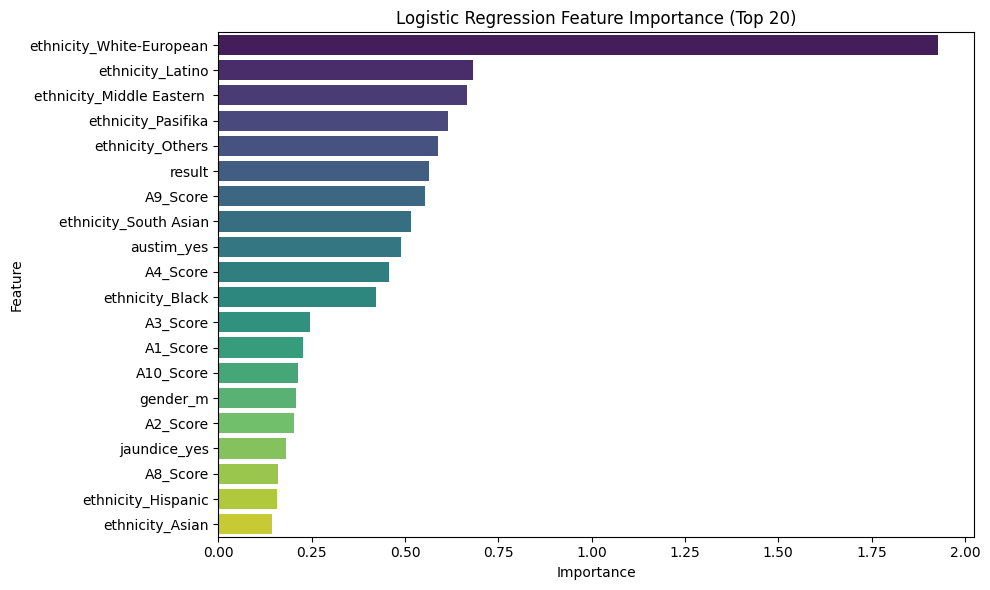


Training and evaluating: Random Forest
Random Forest Test Accuracy: 0.8313 | ROC-AUC: 0.8660 | PR-AUC: 0.6257 | F1: 0.6400 | MCC: 0.5428


C:\Users\Draupniyr\AppData\Local\Temp\ipykernel_32188\876219692.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), palette='viridis')


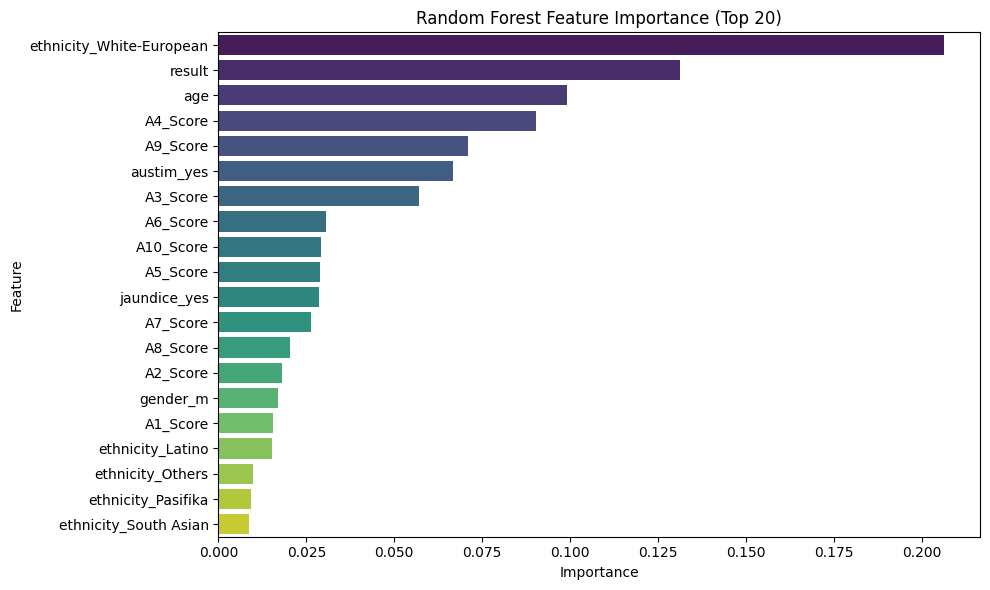


Training and evaluating: XGBoost
XGBoost Test Accuracy: 0.8063 | ROC-AUC: 0.8376 | PR-AUC: 0.5607 | F1: 0.5974 | MCC: 0.4865


C:\Users\Draupniyr\AppData\Local\Temp\ipykernel_32188\876219692.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), palette='viridis')


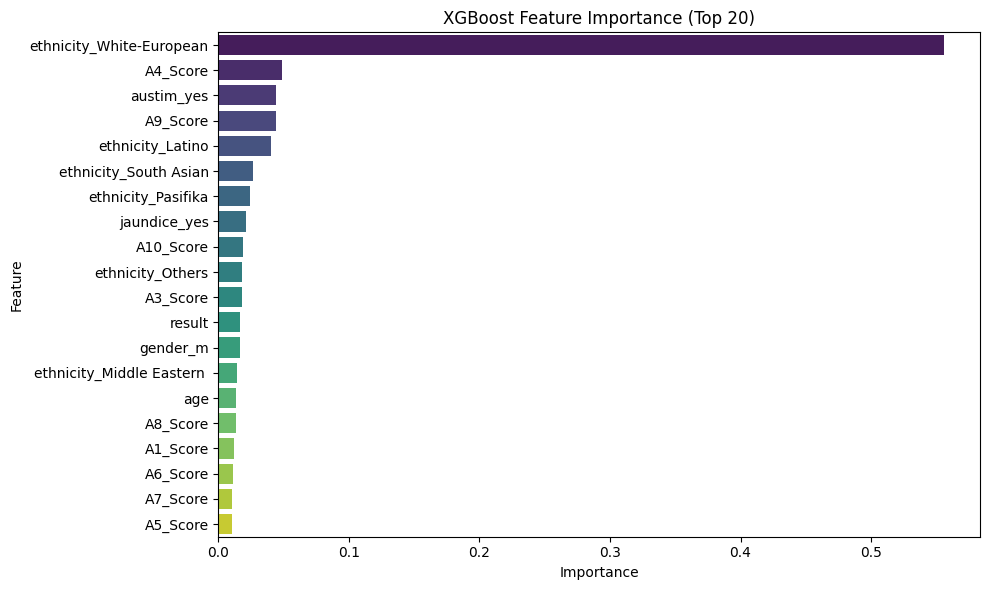


Training and evaluating: CatBoost
CatBoost Test Accuracy: 0.7937 | ROC-AUC: 0.8550 | PR-AUC: 0.6175 | F1: 0.5479 | MCC: 0.4223


C:\Users\Draupniyr\AppData\Local\Temp\ipykernel_32188\876219692.py:240: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), palette='viridis')


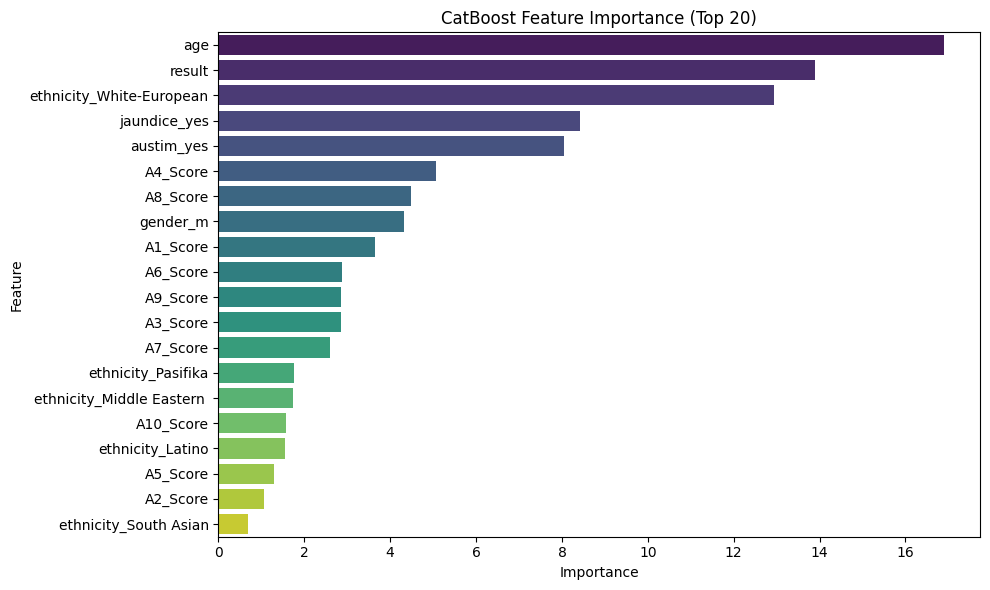

,accuracy,roc_auc,pr_auc,f1,mcc
Logistic Regression,0.78125,0.843018,0.619767,0.578313,0.462723
Random Forest,0.83125,0.865967,0.625676,0.640000,0.542792
XGBoost,0.80625,0.837646,0.560746,0.597403,0.486534
CatBoost,0.79375,0.854980,0.617536,0.547945,0.422335


In [18]:
print(train.shape)
train.drop(columns=['contry_of_res', 'relation', 'used_app_before'], inplace=True)
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('Class/ASD') # Remove target from numerical features
print(numerical_cols)
print(categorical_cols)
# ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'result']
# ['gender', 'ethnicity', 'jaundice', 'austim']

# Encode categorical features using one-hot encoding
df_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)
print(df_encoded.head())

# Separate features (X) and target (y)
X = df_encoded.drop('Class/ASD', axis=1)
y = df_encoded['Class/ASD']

# Split into training and testing sets
seed = 16
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed
)

# Adasyn
adasyn = ADASYN(random_state=seed)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# Shape of our data
display(X.head())
print(X.shape)
display(y.head())
print(y.shape)

# Setup
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=17)
scaler = StandardScaler()

# Helper: get class weights for boosting classes
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

def tune_logreg(X, y, scaler):
    def objective(trial):
        penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
        C = trial.suggest_float("C", 1e-3, 10, log=True)
        kws = {"penalty": penalty, "solver": "saga", "C": C,
               "max_iter": 5000, "class_weight": "balanced", "random_state": 17}
        if penalty == "elasticnet":
            kws["l1_ratio"] = trial.suggest_float("l1_ratio", 0, 1)
        model = LogisticRegression(**kws)
        return cross_val_score(model, scaler.fit_transform(X), y, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=40, show_progress_bar=False)
    return study.best_params

def tune_rf(X, y):
    def objective(trial):
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 50, 300),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            class_weight="balanced", random_state=17, n_jobs=-1)
        return cross_val_score(model, X, y, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=40, show_progress_bar=False)
    return study.best_params

def tune_xgb(X, y):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            'random_state': 17,
            'scale_pos_weight': scale_pos_weight,
            'eval_metric': 'logloss'
        }
        model = XGBClassifier(**params)
        return cross_val_score(model, X, y, cv=cv, scoring="balanced_accuracy").mean()
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=40, show_progress_bar=False)
    return study.best_params

def tune_cat(X, y):
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 50, 200),
            'depth': trial.suggest_int('depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'random_state': 17,
            'scale_pos_weight': scale_pos_weight,
            'verbose': False
        }
        model = CatBoostClassifier(**params)
        return cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy').mean()
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=40, show_progress_bar=False)
    return study.best_params

print("Tuning Logistic Regression...")
params_lr = tune_logreg(X_train_bal, y_train_bal, scaler)
print("Tuning Random Forest...")
params_rf = tune_rf(X_train_bal, y_train_bal)
print("Tuning XGBoost...")
params_xgb = tune_xgb(X_train_bal, y_train_bal)
print("Tuning CatBoost...")
params_cat = tune_cat(X_train_bal, y_train_bal)

# Train final models with best params
trained_models = {}
results = {}

# Define model configurations
model_configs = {
    "Logistic Regression": {
        "model_class": LogisticRegression,
        "params": params_lr,
        "extra_params": {
            "max_iter": 5000,
            "class_weight": "balanced",
            "random_state": 17,
            "solver": "saga"
        },
        "needs_scaling": True,
        "special_handling": lambda params: (
            # Remove l1_ratio if penalty is not 'elasticnet'
            {k: v for k, v in params.items() if k != 'l1_ratio' or params.get('penalty') == 'elasticnet'}
        )
    },
    "Random Forest": {
        "model_class": RandomForestClassifier,
        "params": params_rf,
        "extra_params": {
            "class_weight": "balanced",
            "random_state": 17,
            "n_jobs": -1
        },
        "needs_scaling": False
    },
    "XGBoost": {
        "model_class": XGBClassifier,
        "params": params_xgb,
        "extra_params": {
            "eval_metric": "logloss",
            "random_state": 17
        },
        "needs_scaling": False
    },
    "CatBoost": {
        "model_class": CatBoostClassifier,
        "params": params_cat,
        "extra_params": {
            "verbose": False,
            "random_state": 17
        },
        "needs_scaling": False
    }
}

# Function to get feature importance
def get_feature_importance(model, name):
    if name == "Logistic Regression":
        return np.abs(model.coef_[0])
    elif name in ["Random Forest", "XGBoost"]:
        return model.feature_importances_
    elif name == "CatBoost":
        return model.get_feature_importance()
    return None

# Train and evaluate each model
for name, config in model_configs.items():
    print(f"\nTraining and evaluating: {name}")
    
    # Prepare model parameters
    model_params = config["params"].copy()
    model_params.update(config["extra_params"])
    
    # Apply special parameter handling if needed
    if "special_handling" in config:
        model_params = config["special_handling"](model_params)
    
    # Create and train model
    model = config["model_class"](**model_params)
    
    # Handle data scaling if needed
    X_train_data = scaler.fit_transform(X_train_bal) if config["needs_scaling"] else X_train_bal
    X_test_data = scaler.transform(X_test) if config["needs_scaling"] else X_test
    
    # Fit model
    model.fit(X_train_data, y_train_bal)
    
    # Make predictions
    y_pred = model.predict(X_test_data)
    
    # Get probabilities for ROC/PR curves
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_data)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_data)
    else:
        y_proba = y_pred  # fallback
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # Store results
    results[name] = {
        'accuracy': acc,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'f1': f1,
        'mcc': mcc,
    }
    trained_models[name] = model
    
    print(f"{name} Test Accuracy: {acc:.4f} | ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f} | F1: {f1:.4f} | MCC: {mcc:.4f}")
    
    # Feature importance plot
    importance = get_feature_importance(model, name)
    if importance is not None:
        plt.figure(figsize=(10, 6))
        feature_names = X_train.columns
        feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)
        sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), palette='viridis')
        plt.title(f"{name} Feature Importance (Top 20)")
        plt.tight_layout()
        plt.show()

results_df = pd.DataFrame(results).T
display(results_df)


## She giving me Neural til I Net

Epoch 1/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - auc_2: 0.4382 - loss: 11.8408 - val_accuracy: 0.0000e+00 - val_auc_2: 0.8318 - val_loss: 5.1232 - learning_rate: 0.0010
Epoch 2/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - auc_2: 0.8688 - loss: 3.6944 - val_accuracy: 0.0000e+00 - val_auc_2: 0.9118 - val_loss: 0.8623 - learning_rate: 0.0010
Epoch 3/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - auc_2: 0.8687 - loss: 0.6853 - val_accuracy: 0.0000e+00 - val_auc_2: 0.9127 - val_loss: 0.5043 - learning_rate: 0.0010
Epoch 4/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - auc_2: 0.9141 - loss: 0.4457 - val_accuracy: 0.0000e+00 - val_auc_2: 0.9156 - val_loss: 0.4463 - learning_rate: 0.0010
Epoch 5/60
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - auc_2: 0.9219 - loss: 0.4334 - val_accuracy: 0.0000e+00 - val_auc_2: 0.9237 - val_loss: 0.4625 - learning_rate: 0.0010
Epoch 6/60
116/116 

<Axes: >

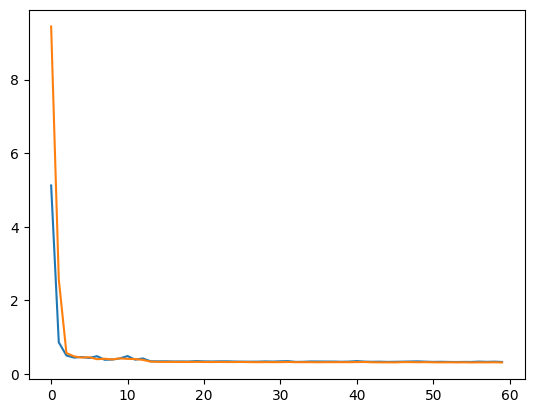

In [23]:
import tensorflow as tf
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split

eth_label = train.loc[:,['ethnicity','Class/ASD']]
mapper = {
    '?' : 'others',
    'Others' : 'others'
}
eth_label['ethnicity'] = eth_label['ethnicity'].map(lambda x : mapper[x] if x in mapper else x)
eth_label = (eth_label[eth_label['Class/ASD'] == 1]['ethnicity'].value_counts() / eth_label[eth_label['Class/ASD'] == 0]['ethnicity'].value_counts() * eth_label['ethnicity'].value_counts()).sort_values(ascending=False)
eth_label = eth_label.map(lambda x : 0 if np.isnan(x) else x)
eth_label = dict((eth_label - min(eth_label))/(max(eth_label) - min(eth_label)))

def preprocess(data : pd.DataFrame):
    data_temp = data.copy()
    data_temp['gender'] = data_temp['gender'].map(lambda x : 1 if x == 'm' else 0)
    data_temp['jaundice'] = data_temp['jaundice'].map(lambda x : 1 if x == 'yes' else 0)
    data_temp['austim'] = data_temp['austim'].map(lambda x : 1 if x == 'yes' else 0)
    data_temp['ethnicity'] = data_temp['ethnicity'].map(lambda x : 'others' if (x == 'Others' or x == '?') else x)
    data_temp['ethnicity'] = data_temp['ethnicity'].map(eth_label)
    data_temp['age'] = (data_temp['age'] - min(data_temp['age']))/(max(data_temp['age']) - min(data_temp['age']))
    data_temp['result'] = (data_temp['result'] - min(data_temp['result']))/(max(data_temp['result']) - min(data_temp['result']))
    return data_temp

data_train_preprocess = preprocess(train)

x_train,x_test,y_train,y_test = train_test_split(data_train_preprocess.drop('Class/ASD',axis=1),data_train_preprocess['Class/ASD'])



ovr = ADASYN()
und = TomekLinks()
x_train_neural,y_train_neural = ovr.fit_resample(x_train,y_train)
x_train_neural,y_train_neural = und.fit_resample(x_train,y_train)



model = tf.keras.Sequential(
    [
        tf.keras.Input(shape = (x_train_neural.shape[1],)),
        tf.keras.layers.Dense(64, activation="relu", name="layer1",kernel_regularizer = tf.keras.regularizers.L1(l1=0.1),),
        tf.keras.layers.Dense(32, activation="relu", name="layer2"),
        tf.keras.layers.Dense(16, activation="relu", name="layer3"),
        tf.keras.layers.Dense(1, activation = 'sigmoid',name="output")
    ]
)

model(x_train_neural.values[0:1])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy(),tf.keras.metrics.AUC()],
)

callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=5,
        verbose=1,
        min_lr=0.0001,
    )
]

history = model.fit(
    x_train_neural,
    y_train_neural,
    batch_size=5,
    epochs=60,
    callbacks= callbacks,
    validation_data=(x_test, y_test),
)

sns.lineplot(x = [x for x in range(0,len(history.history['val_loss']))],y= history.history['val_loss'])
sns.lineplot(x = [x for x in range(0,len(history.history['loss']))],y= history.history['loss'])


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy Score: 0.8800
ROC-AUC Score: 0.9129
PR-AUC Score (Average Precision): 0.6440


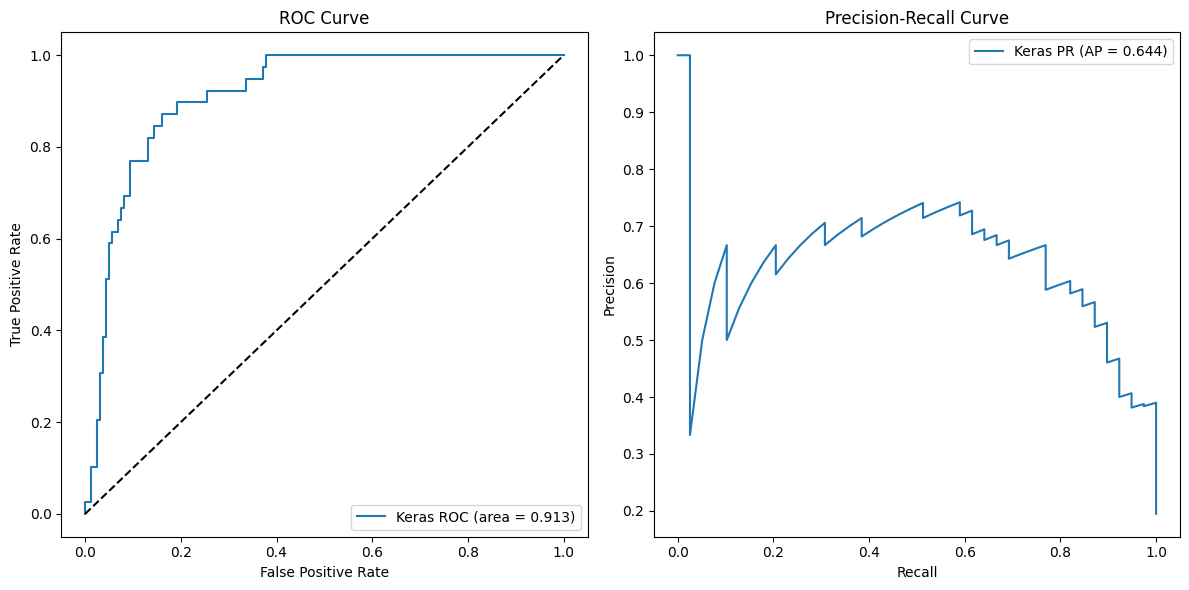

F1 Score: 0.7143
Matthews Correlation Coefficient (MCC): 0.6414


In [25]:
from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score, matthews_corrcoef, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

out_probs = model.predict(x_test) # These are probabilities

out_binary = (out_probs > 0.5).astype(int)

# 0. Accuracy
acc = accuracy_score(y_test, out_binary)
print(f"Accuracy Score: {acc:.4f}")

# 1. ROC Curve and ROC-AUC Score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, out_probs)
auc_keras = auc(fpr_keras, tpr_keras)

print(f"ROC-AUC Score: {auc_keras:.4f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr_keras, tpr_keras, label='Keras ROC (area = {:.3f})'.format(auc_keras))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

# 2. Precision-Recall Curve and PR-AUC (Average Precision)
precision, recall, thresholds_pr = precision_recall_curve(y_test, out_probs)
pr_auc_score = average_precision_score(y_test, out_probs) # This is a common way to get PR-AUC

print(f"PR-AUC Score (Average Precision): {pr_auc_score:.4f}")


plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Keras PR (AP = {:.3f})'.format(pr_auc_score))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 3. F1-Score
f1 = f1_score(y_test, out_binary)
print(f"F1 Score: {f1:.4f}")

# 4. Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, out_binary)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")